# SETUP & LIBARY IMPORTS

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

import warnings
# Supress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. DATA LOADING & INITIAL EXPLORATION

In [2]:
# Laod the weather dataset 
df = pd.read_csv(r'../data/GlobalWeatherRepository.csv')
df['last_updated'] = pd.to_datetime(df['last_updated'])

In [3]:
# Display the first few rows of the dataset
print("Dataset Preview (First 5 Rows):")
display(df.head())

Dataset Preview (First 5 Rows):


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15:00,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45:00,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45:00,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45:00,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45:00,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [4]:
print(f"Dataset Shape: {df.shape}")
df.info()

Dataset Shape: (62948, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62948 entries, 0 to 62947
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   country                       62948 non-null  object        
 1   location_name                 62948 non-null  object        
 2   latitude                      62948 non-null  float64       
 3   longitude                     62948 non-null  float64       
 4   timezone                      62948 non-null  object        
 5   last_updated_epoch            62948 non-null  int64         
 6   last_updated                  62948 non-null  datetime64[ns]
 7   temperature_celsius           62948 non-null  float64       
 8   temperature_fahrenheit        62948 non-null  float64       
 9   condition_text                62948 non-null  object        
 10  wind_mph                      62948 non-null  float64       
 11  w

In [6]:
# Determine the base directory (Project folder) relative to this script
base_path = os.path.abspath(os.path.join(os.path.dirname('Weather-Trend-Forecasting'), '..'))
# Construct the path for the Visualization folder
save_dir = os.path.join(base_path, 'Visualization')

# Ensure the Visualization folder exists; if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 2. DATA CLEANING & PREPROCESSING
    1. Handle Missing Values
    2. Handling Outliers
    3. Normalize Data

### 2.1 Handling Missing Values 
    - Currently, the dataset has no missing values for all columns. This function handle_missing_values() is designed for future purposes.

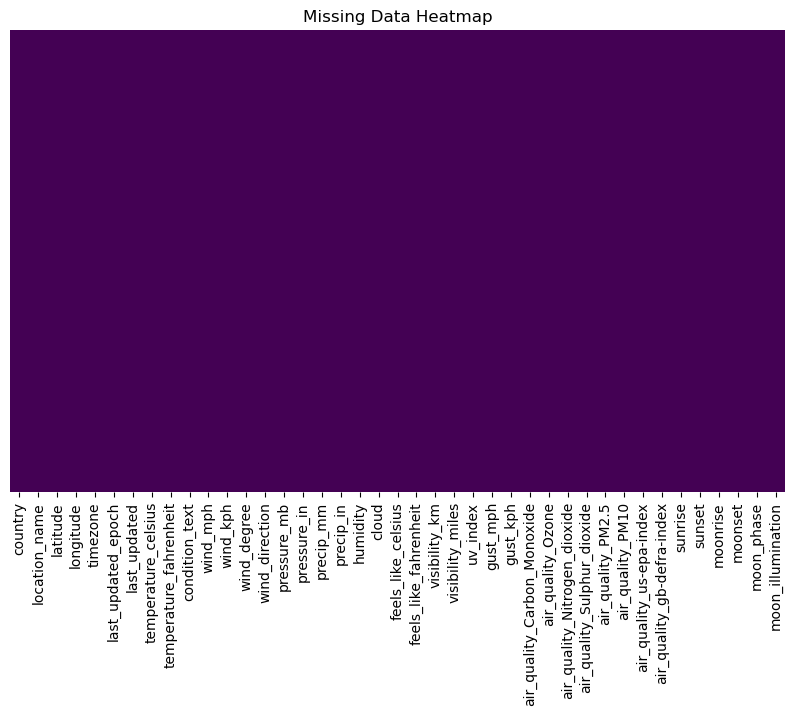

In [8]:
# Visualize missing data using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
# save_path = os.path.join(save_dir, "01_missing_values_heat_map.png")
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.title("Missing Data Heatmap")
plt.show()

In [9]:
# Print missing values per column
missing_values = df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone

In [10]:
def handle_missing_values(df):
    """
    Handles missing values in the dataset intelligently based on column type.
    Parameters:
        df (pd.DataFrame): DataFrame with potential missing values.   
    Returns:
        pd.DataFrame: DataFrame with missing values handled appropriately.
    """
    
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        
        if missing_count > 0:
            print(f"Processing '{col}' ({df[col].dtype}) with {missing_count} missing values.")
            
            # Numerical columns
            if df[col].dtype in ['float64', 'int64']:
                if col in ['latitude', 'longitude']:
                    # Geographic coordinates - use median
                    fill_val = df[col].median()
                    df[col].fillna(fill_val, inplace=True)
                    print(f"Filled numerical (geographical) '{col}' with median: {fill_val}")
                
                elif col == 'last_updated_epoch':
                    # Epoch timestamps: forward-fill/backward-fill to maintain temporal context
                    df[col].fillna(method='ffill', inplace=True)
                    df[col].fillna(method='bfill', inplace=True)
                    print(f"Filled timestamp '{col}' with forward/backward-fill.")
                
                else:
                    # General numeric columns: use mean or median
                    fill_val = df[col].median()  # Using median to handle skewness/outliers
                    df[col].fillna(fill_val, inplace=True)
                    print(f"Filled numerical '{col}' with median: {fill_val}")
            
            # Categorical or textual columns
            elif df[col].dtype == 'object':
                # Fill with mode
                fill_val = df[col].mode()[0]
                df[col].fillna(fill_val, inplace=True)
                print(f"Filled categorical '{col}' with mode: '{fill_val}'")
                
            # Datetime columns (string representations)
            else:
                # Forward-fill/backward-fill for datetime strings
                df[col].fillna(method='ffill', inplace=True)
                df[col].fillna(method='bfill', inplace=True)
                print(f"Filled datetime '{col}' with forward/backward-fill.")
    
    print("Missing value handling complete.")
    return df

In [11]:
# Apply missing value handling
df_cleaned = handle_missing_values(df.copy())

Missing value handling complete.


### 2.2 Handling Outliers
    - Outlier detection and correction perfomed individually per country

In [12]:
def handle_outliers_by_country(df, visualize=False):
    """
    Detect and handle outliers within each country separately.
    Outliers replaced by country-specific median.
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    grouped = df.groupby('country')
    
    outlier_summary = []

    for col in numeric_cols:
        total_outliers = 0
        
        def process_group(group):
            nonlocal total_outliers
            Q1 = group[col].quantile(0.25)
            Q3 = group[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = group[(group[col] < lower_bound) | (group[col] > upper_bound)]
            num_outliers = outliers.shape[0]
            total_outliers += num_outliers
            
            median = group[col].median()
            group[col] = group[col].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
            
            return group
        
        df = grouped.apply(process_group).reset_index(drop=True)
        
        percent_outliers = (total_outliers / df.shape[0]) * 100
        outlier_summary.append({
            'column': col,
            'num_outliers': total_outliers,
            'percent_outliers': percent_outliers
        })

        # Visualization
        if visualize and total_outliers > 0:
            plt.figure(figsize=(8, 4))
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot after country-wise handling of {col}')
            plt.xlabel(col)
            plt.show()

    outlier_df = pd.DataFrame(outlier_summary).sort_values(by='percent_outliers', ascending=False)
    print("\nCountry-wise outlier summary:")
    print(outlier_df)

    return df

In [13]:
# Handle outliers
df_no_outliers = handle_outliers_by_country(df_cleaned)


Country-wise outlier summary:
                          column  num_outliers  percent_outliers
10                     precip_mm          9832         15.619241
11                     precip_in          6693         10.632586
16                 visibility_km          6224          9.887526
17              visibility_miles          6205          9.857343
28    air_quality_gb-defra-index          3407          5.412404
27      air_quality_us-epa-index          3379          5.367923
24   air_quality_Sulphur_dioxide          2635          4.185995
7                    wind_degree          2541          4.036665
26              air_quality_PM10          2444          3.882570
23  air_quality_Nitrogen_dioxide          2422          3.847620
25             air_quality_PM2.5          2062          3.275720
13                         cloud          2051          3.258245
21   air_quality_Carbon_Monoxide          1991          3.162928
19                      gust_mph          1213          1.9

## 2.3 Normalizing Data
    - The columns with continuous numeric values should only be normalized 
        [
        'temperature_celsius', 'temperature_fahrenheit',
        'feels_like_celsius', 'feels_like_fahrenheit',
        'wind_mph', 'wind_kph', 'gust_mph', 'gust_kph',
        'pressure_mb', 'pressure_in',
        'precip_mm', 'precip_in',
        'visibility_km', 'visibility_miles',
        'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 
        'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
        'air_quality_PM2.5', 'air_quality_PM10'
        ]
    - Categorical, Textual, epoch-based timestamp, and datetime columns should never be directly normalize

In [14]:
def normalize_data(df):
    """
    Normalize the safe numeric columns using StandardScaler.
    Returns the DataFrame with normalized columns.
    """ 
    numeric_cols = [
        'temperature_celsius', 'temperature_fahrenheit',
        'feels_like_celsius', 'feels_like_fahrenheit',
        'wind_mph', 'wind_kph', 'gust_mph', 'gust_kph',
        'pressure_mb', 'pressure_in',
        'precip_mm', 'precip_in',
        'visibility_km', 'visibility_miles',
        'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 
        'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
        'air_quality_PM2.5', 'air_quality_PM10'
    ]

    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    print("Selected numeric columns have been standardized (mean=0, std=1).")
    return df

In [15]:
# Normalize safe numeric columns
df_normalize = normalize_data(df_no_outliers.copy())

Selected numeric columns have been standardized (mean=0, std=1).


# 3. Exploratory Data Analysis
    1. Perform basic EDA to uncover the trends, correlations, and patterns.
    2. Generate visualizations for temperature and precipitation

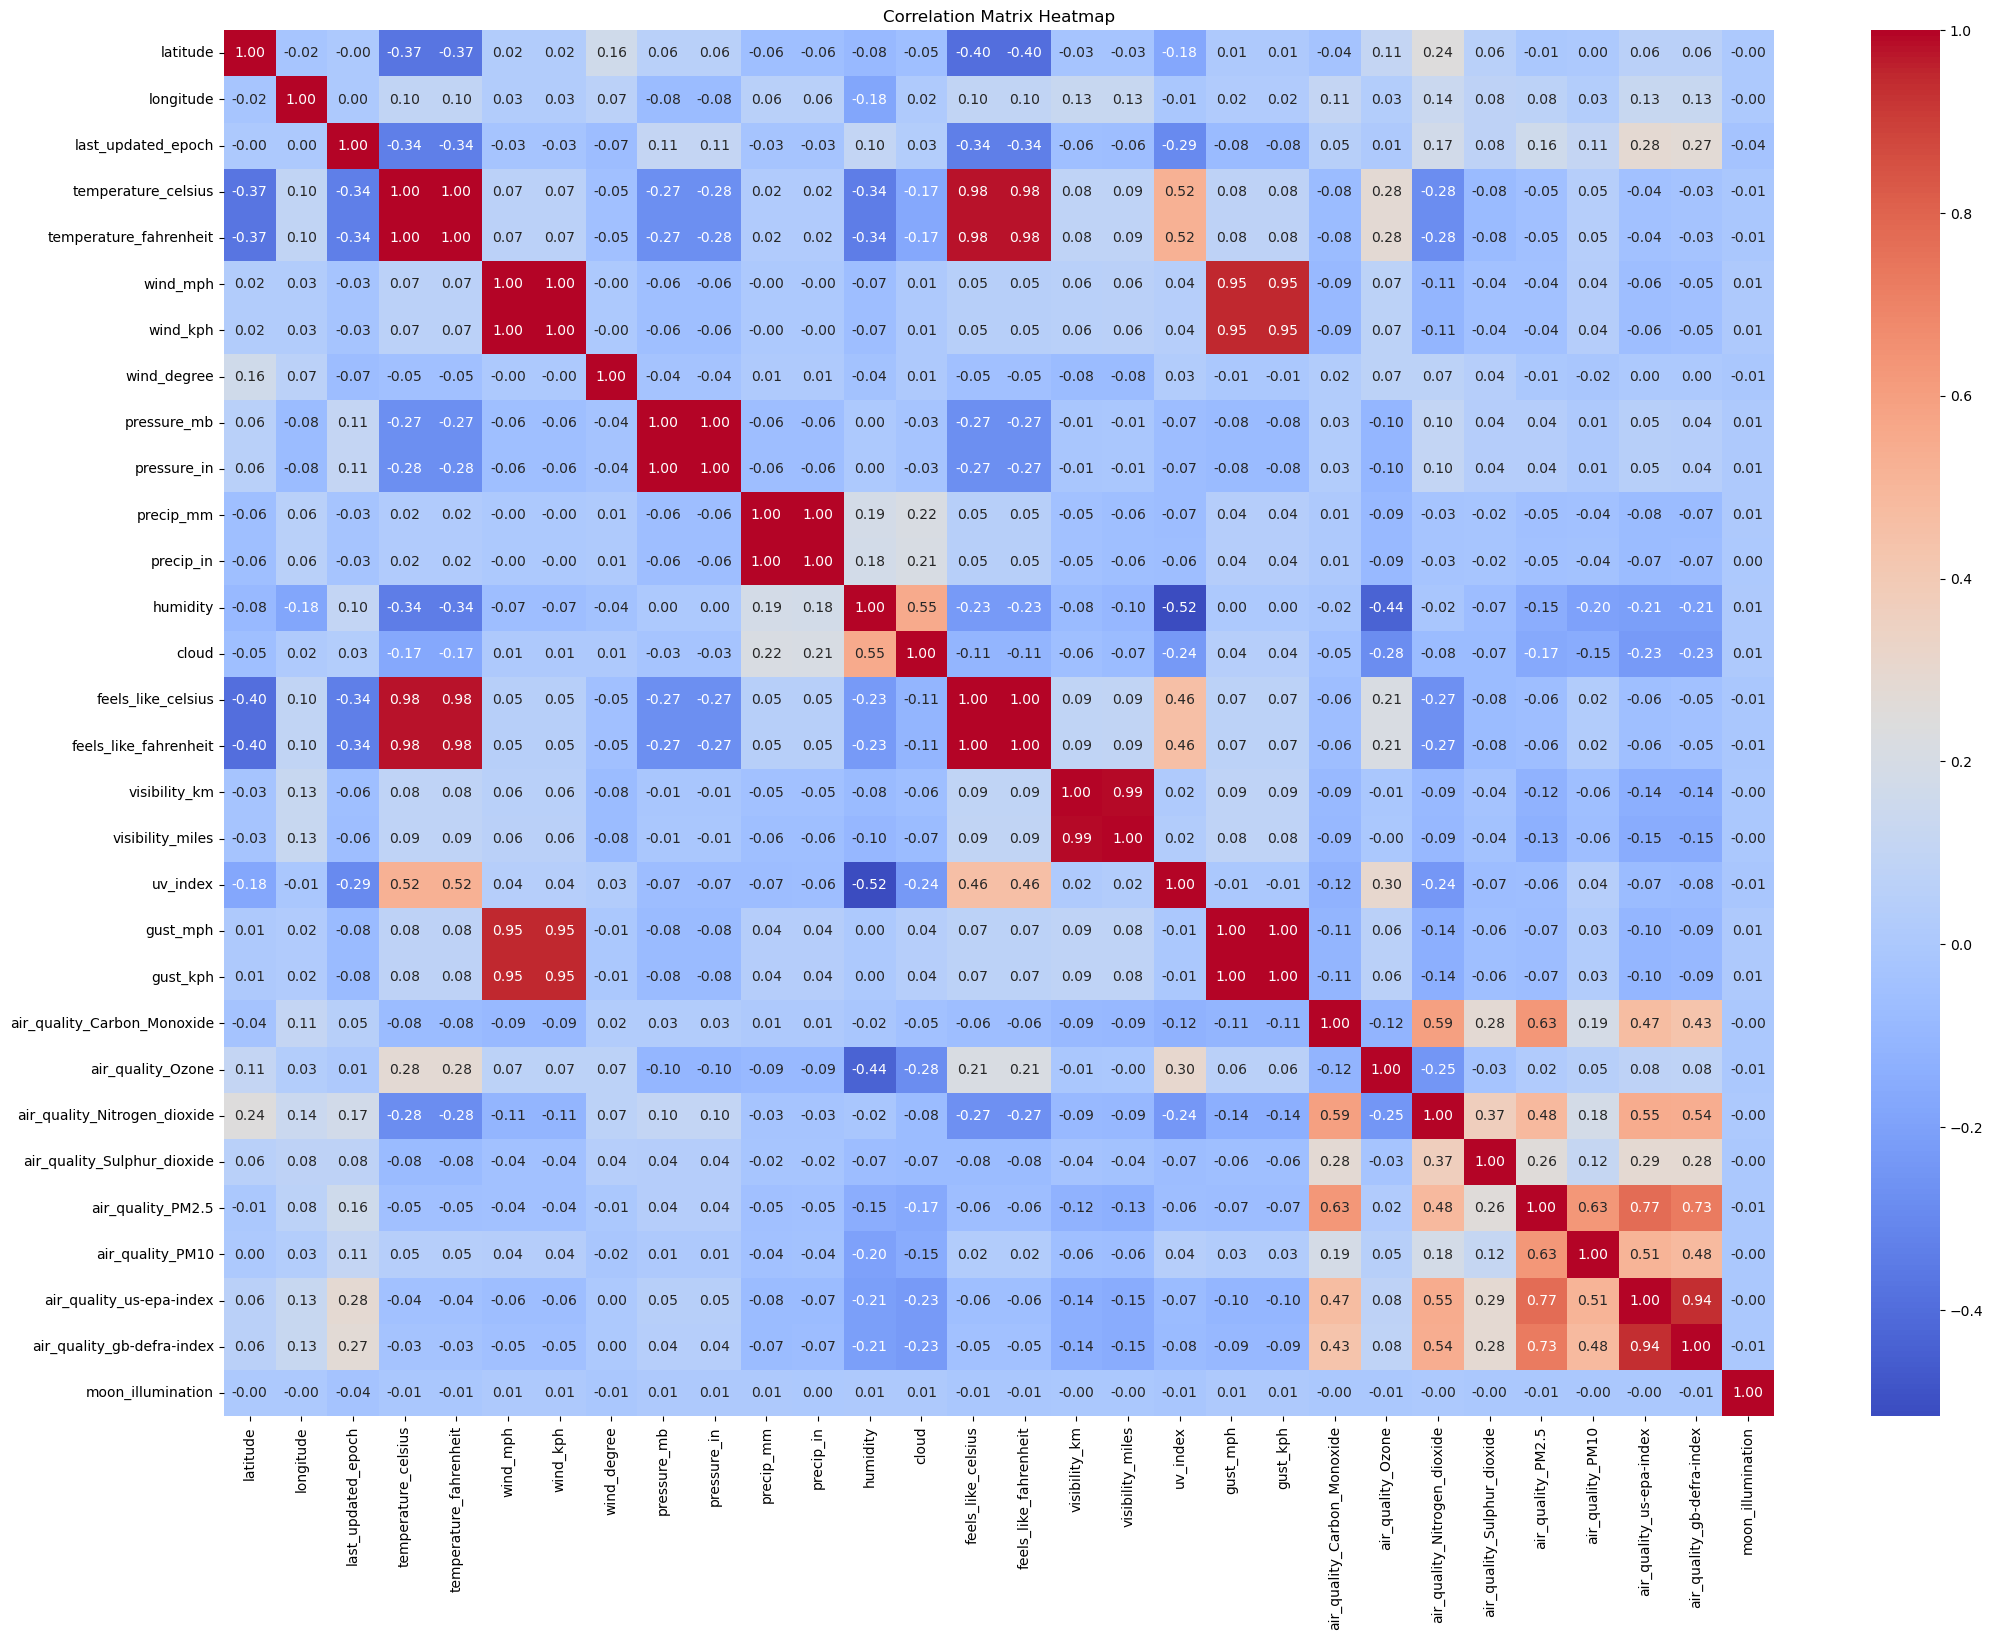

In [16]:
# Correlation MAtrix Heatmap (For numerical Features)
plt.figure(figsize=(25,18))
numeric_features = df_no_outliers.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df_no_outliers[numeric_features].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
# save_path = os.path.join(save_dir, "02_EDA_heat_map.png")
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.title("Correlation Matrix Heatmap")
plt.show()

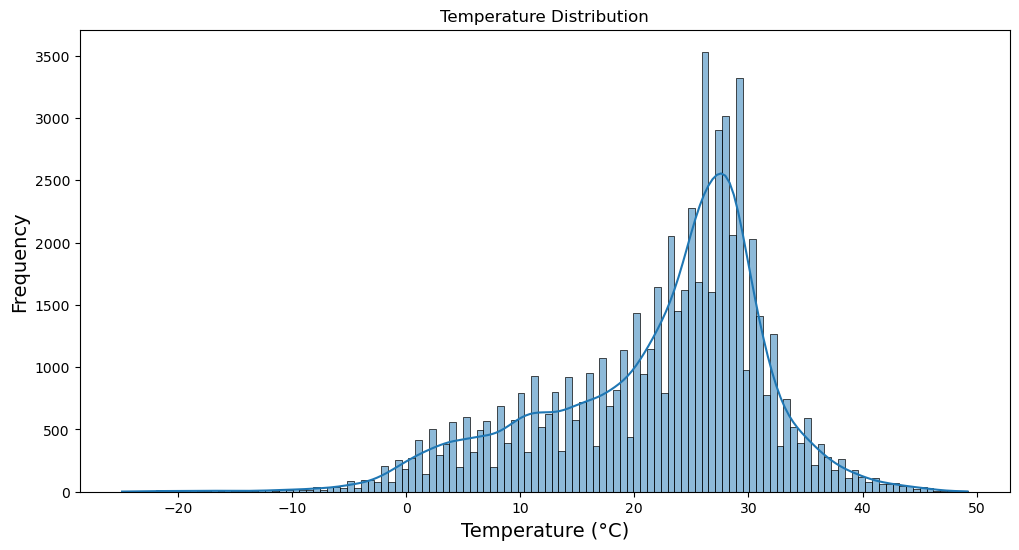

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(df_no_outliers['temperature_celsius'], kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# save_path = os.path.join(save_dir, "03_EDA_temperature_distribution.png")
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

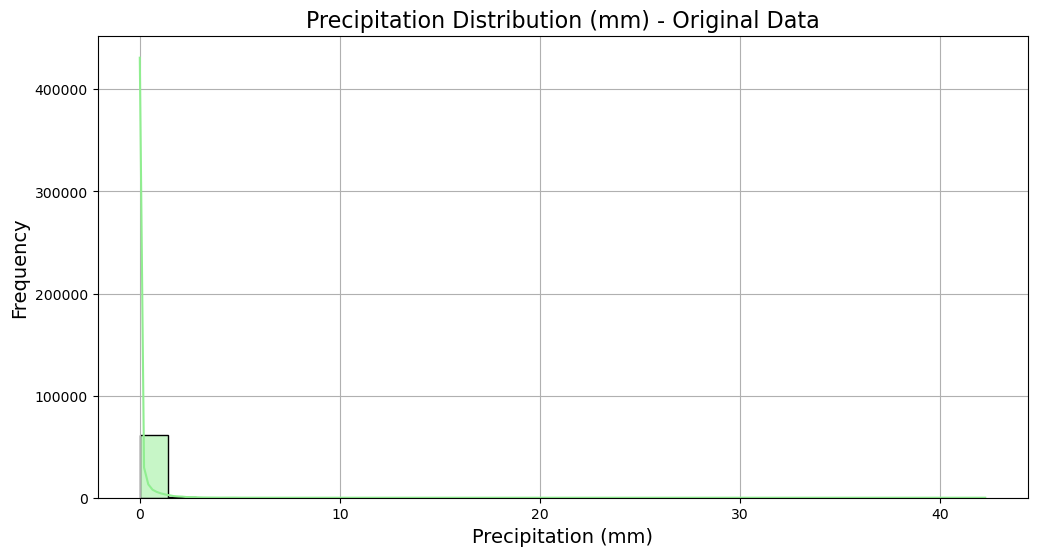

In [19]:
# Precipitation distribution visualization
plt.figure(figsize=(12, 6))
sns.histplot(df_no_outliers['precip_mm'], kde=True, bins=30, color='lightgreen')
plt.title('Precipitation Distribution (mm) - Original Data', fontsize=16)
plt.xlabel('Precipitation (mm)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# save_path = os.path.join(save_dir, "04_EDA_precipitation_distribution.png")
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

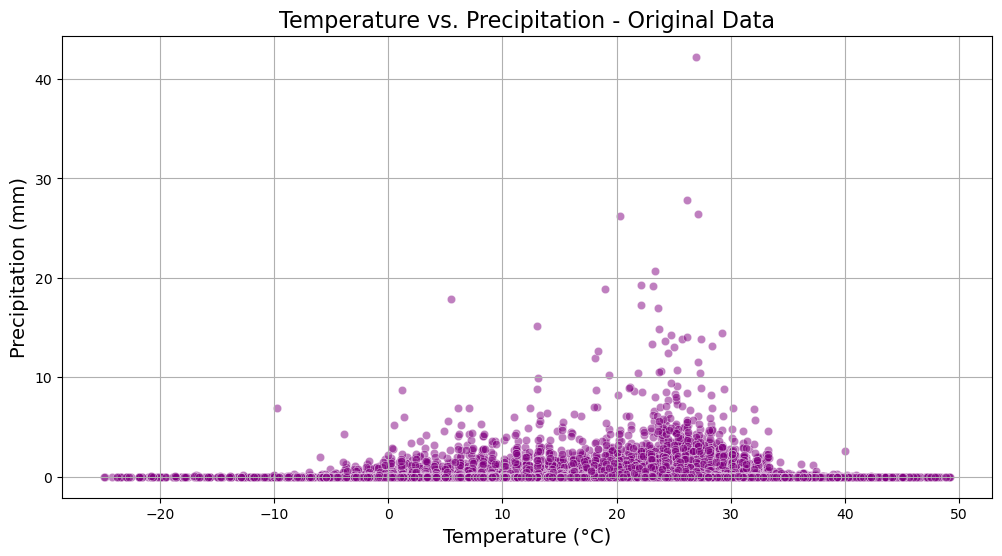

In [20]:
# Temperature vs. Precipitation (original data)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_no_outliers, x='temperature_celsius', y='precip_mm', alpha=0.5, color='purple')
plt.title('Temperature vs. Precipitation - Original Data', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Precipitation (mm)', fontsize=14)
# save_path = os.path.join(save_dir, "05_EDA_temperature_vs_precipitation.png")
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

# MODEL BUIDLING
    - Time-series Forecasting Model using SARIMAX using Each Country

In [21]:
# Function to train and forecast SARIMA model for a specific country
def forecast_temperature_by_country(country_name):
    country_df = df_no_outliers[df_no_outliers['country'] == country_name]
    country_df.set_index('last_updated', inplace=True)

    # Select top features
    features = [
        'temperature_celsius', 'feels_like_celsius', 'uv_index', 'wind_mph', 'humidity', 'pressure_mb',
        'air_quality_Nitrogen_dioxide', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone'
    ]

    # Resample to daily means
    daily_df = country_df[features].resample('D').mean().dropna()

    if len(daily_df) < 30:
        print(f"Not enough data for {country_name}.")
        return

    # Split into target and exogenous variables
    target = daily_df['temperature_celsius']
    exog = daily_df.drop(columns=['temperature_celsius'])

    # Train-test split
    train_size = int(len(daily_df) * 0.8)
    y_train, y_test = target[:train_size], target[train_size:]
    exog_train, exog_test = exog[:train_size], exog[train_size:]

    # Fit SARIMAX
    model = SARIMAX(y_train, exog=exog_train, order=(1,1,1), seasonal_order=(1,1,1,12))
    model_fit = model.fit(disp=False)

    # Forecast
    forecast = model_fit.forecast(steps=len(y_test), exog=exog_test)

    # Evaluation
    mae = mean_absolute_error(y_test, forecast)
    rmse = mean_squared_error(y_test, forecast, squared=False)
    mape = mean_absolute_percentage_error(y_test, forecast)
    r2 = r2_score(y_test, forecast)

    print(f'\nCountry: {country_name}')
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2%}')
    print(f'R²: {r2:.2f}')

    # Plot
    plt.figure(figsize=(14,6))
    plt.plot(y_train.index, y_train, label='Train')
    plt.plot(y_test.index, y_test, label='Actual', color='blue')
    plt.plot(y_test.index, forecast, label='Forecast', color='red')
    plt.title(f'SARIMAX Forecast - Temperature for {country_name}')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    
    plt.show()


Country: India
MAE: 1.78
RMSE: 2.13
MAPE: 5.88%
R²: 0.75


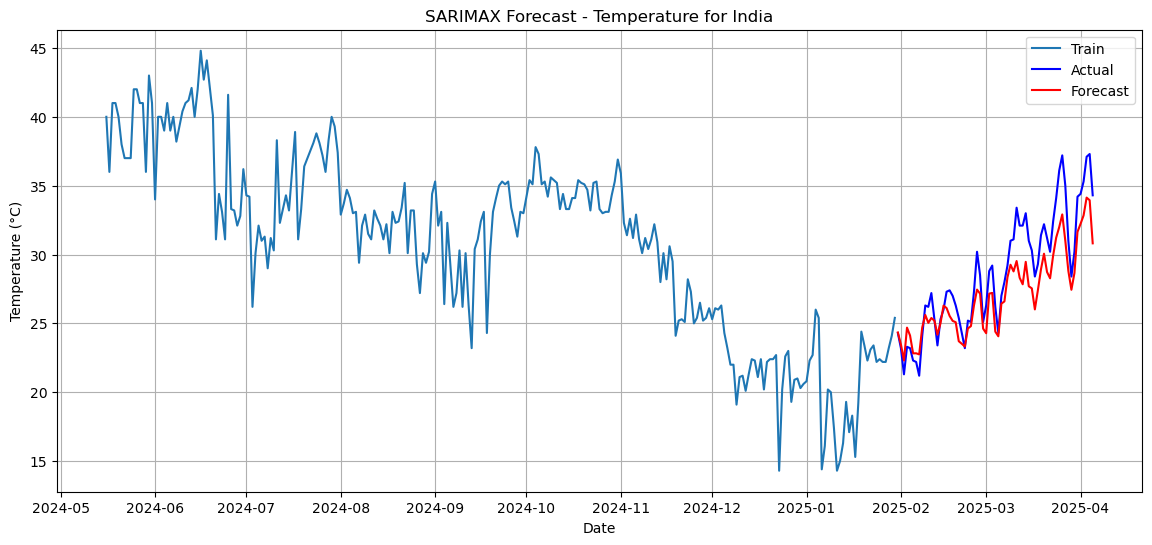

In [22]:
# Example Usage: Forecast for a specific country
forecast_temperature_by_country('India')


Country: United States of America
MAE: 1.38
RMSE: 1.54
MAPE: 45.37%
R²: 0.73


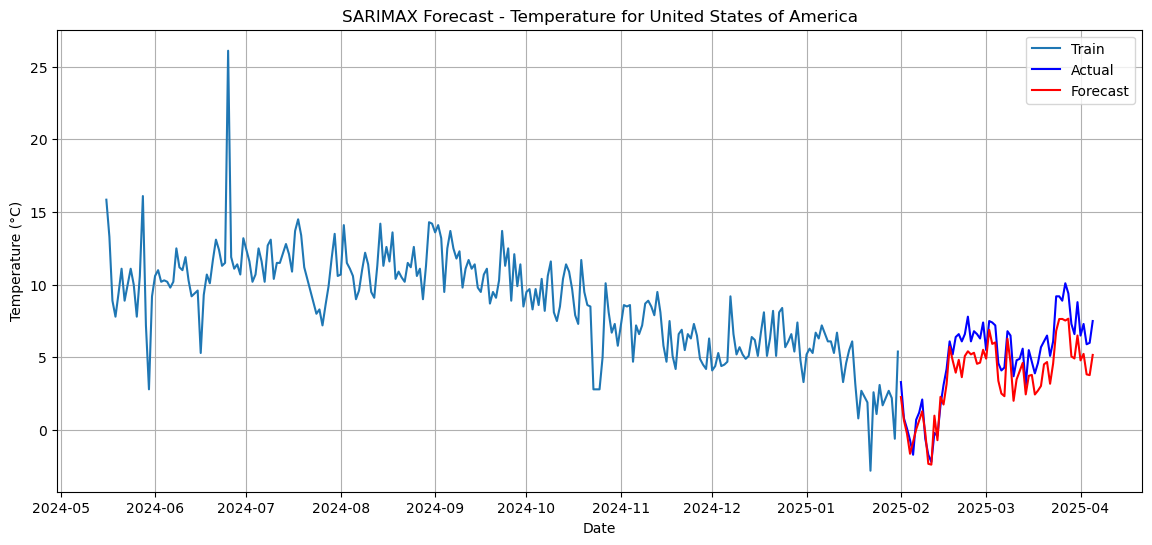

In [23]:
# Example Usage: Forecast for a specific country
forecast_temperature_by_country('United States of America')


Country: United Kingdom
MAE: 0.42
RMSE: 0.54
MAPE: 8.00%
R²: 0.98


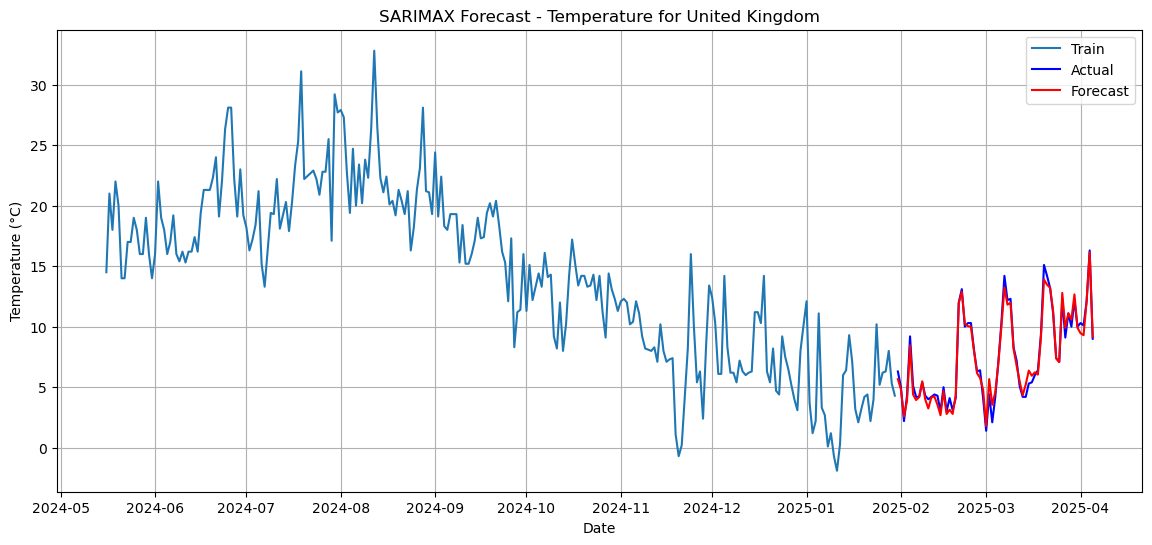

In [24]:
forecast_temperature_by_country('United Kingdom')

# Advanced EDA

In [21]:
# Function to detect anomalies for all countries and all key numeric features
def detect_anomalies_all_countries():
    countries = df_no_outliers['country'].unique()
    numeric_cols = [
        'temperature_celsius', 'humidity', 'wind_kph', 'gust_kph', 'pressure_mb', 'precip_mm',
        'visibility_km', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_Carbon_Monoxide',
        'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_Ozone'
    ]

    for country_name in countries:
        country_df = df_no_outliers[df_no_outliers['country'] == country_name].copy()
        country_df.set_index('last_updated', inplace=True)


        for col in numeric_cols:
            daily_series = country_df[col].resample('D').mean().dropna()
            if len(daily_series) < 30:
                continue

            rolling_mean = daily_series.rolling(window=7, center=True).mean()
            rolling_std = daily_series.rolling(window=7, center=True).std()
            z_scores = (daily_series - rolling_mean) / rolling_std
            anomalies = z_scores[abs(z_scores) > 3]

            if not anomalies.empty:
                print(f"\nCountry: {country_name}")
                print(f"  - {col}: {len(anomalies)} anomalies detected")


In [22]:
# Detect anomalies across all countries and all key features
detect_anomalies_all_countries()

# Forecasting with Multiple Models

In [34]:
# Function to forecast using SARIMA, Linear Regression, Random Forest and Ensemble
def forecast_temperature_by_country(country_name, visualize=False):
    country_df = df_no_outliers[df_no_outliers['country'] == country_name].copy()
    country_df.set_index('last_updated', inplace=True)
    
    # Resample daily, take numeric mean
    daily_df = country_df.resample('D').mean(numeric_only=True).dropna()
    
    # Select top features
    features = [
        'temperature_celsius', 'feels_like_celsius', 'uv_index', 'wind_mph', 'humidity', 'pressure_mb',
        'air_quality_Nitrogen_dioxide', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone'
    ]
    df_model = daily_df[features].copy()

    if len(daily_df) < 50:
        print(f"Not enough data for {country_name}.")
        return

       # Add lag features
    df_model['lag1'] = df_model['temperature_celsius'].shift(1)
    df_model['lag2'] = df_model['temperature_celsius'].shift(2)
    df_model.dropna(inplace=True)
    
    # Train/test split
    train_size = int(len(df_model) * 0.8)
    train = df_model.iloc[:train_size]
    test = df_model.iloc[train_size:]
    
    X_train = train.drop(columns='temperature_celsius')
    y_train = train['temperature_celsius']
    X_test = test.drop(columns='temperature_celsius')
    y_test = test['temperature_celsius']

    # SARIMA (univariate)
    sarima_model = SARIMAX(train['temperature_celsius'], exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_pred = sarima_fit.forecast(steps=len(test), exog=X_test)

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    # XGBoost
    xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    
    # Ensemble: Top 3 (LR, RF, XGB)
    ensemble_pred = (lr_pred + rf_pred + xgb_pred) / 3
    
    # Evaluate models
    models = {
        'SARIMA': sarima_pred,
        'Linear Regression': lr_pred,
        'Random Forest': rf_pred,
        'XGBoost': xgb_pred,
        'Ensemble': ensemble_pred
    }

    print(f"Forecasting Results {country_name}:")
    for name, pred in models.items():
        mae = mean_absolute_error(y_test, pred)
        rmse = mean_squared_error(y_test, pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2%}, R²={r2:.2f}")


    if visualize == True:
        # Visualization
        plt.figure(figsize=(12, 5))
        # Plot actual values
        plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2)
        
        # Plot predictions for each model
        for model_name, pred in models.items():
            plt.plot(y_test.index, pred, label=model_name)
        
        plt.title(f'Temperature Forecast Comparison for {country_name}')
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True)

        # save_path = os.path.join(save_dir, "06_Forecasting_UK.png")
        # plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

Forecasting Results India:
SARIMA: MAE=1.68, RMSE=2.02, MAPE=5.56%, R²=0.77
Linear Regression: MAE=0.71, RMSE=0.86, MAPE=2.53%, R²=0.96
Random Forest: MAE=0.70, RMSE=0.88, MAPE=2.44%, R²=0.96
XGBoost: MAE=0.59, RMSE=0.79, MAPE=2.13%, R²=0.97
Ensemble: MAE=0.59, RMSE=0.71, MAPE=2.08%, R²=0.97


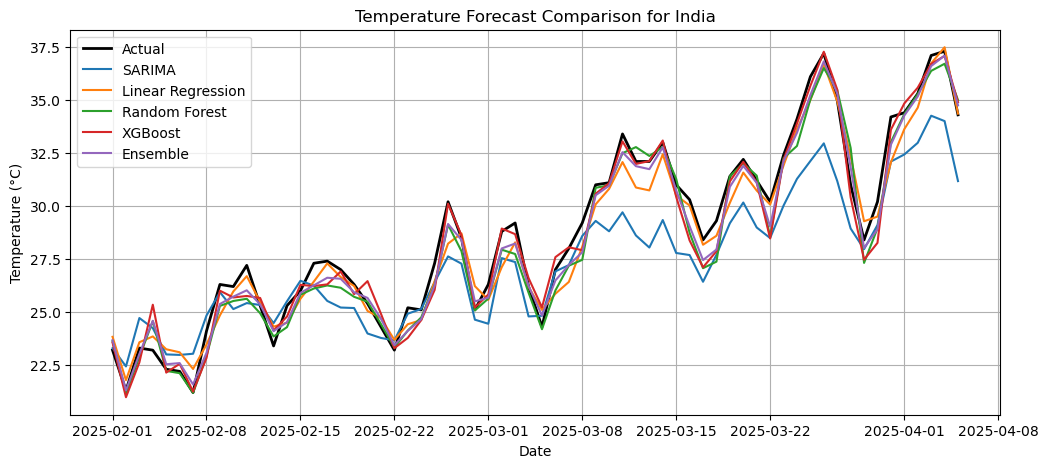

In [31]:
# Example Usage:
forecast_temperature_by_country('India', visualize=True)

Forecasting Results United States of America:
SARIMA: MAE=1.11, RMSE=1.26, MAPE=40.89%, R²=0.82
Linear Regression: MAE=0.41, RMSE=0.50, MAPE=27.00%, R²=0.97
Random Forest: MAE=0.53, RMSE=0.68, MAPE=39.61%, R²=0.95
XGBoost: MAE=0.49, RMSE=0.72, MAPE=52.61%, R²=0.94
Ensemble: MAE=0.39, RMSE=0.53, MAPE=30.68%, R²=0.97


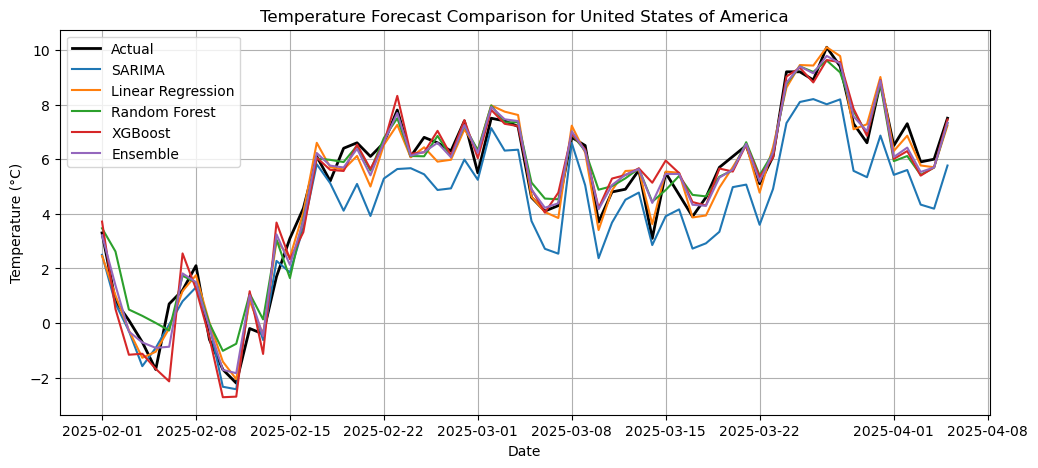

In [33]:
# Example Usage:
forecast_temperature_by_country('United States of America', visualize=True)

Forecasting Results United Kingdom:
SARIMA: MAE=0.49, RMSE=0.65, MAPE=9.76%, R²=0.97
Linear Regression: MAE=0.35, RMSE=0.45, MAPE=7.37%, R²=0.99
Random Forest: MAE=0.52, RMSE=0.71, MAPE=11.53%, R²=0.96
XGBoost: MAE=0.43, RMSE=0.53, MAPE=8.67%, R²=0.98
Ensemble: MAE=0.38, RMSE=0.49, MAPE=8.28%, R²=0.98


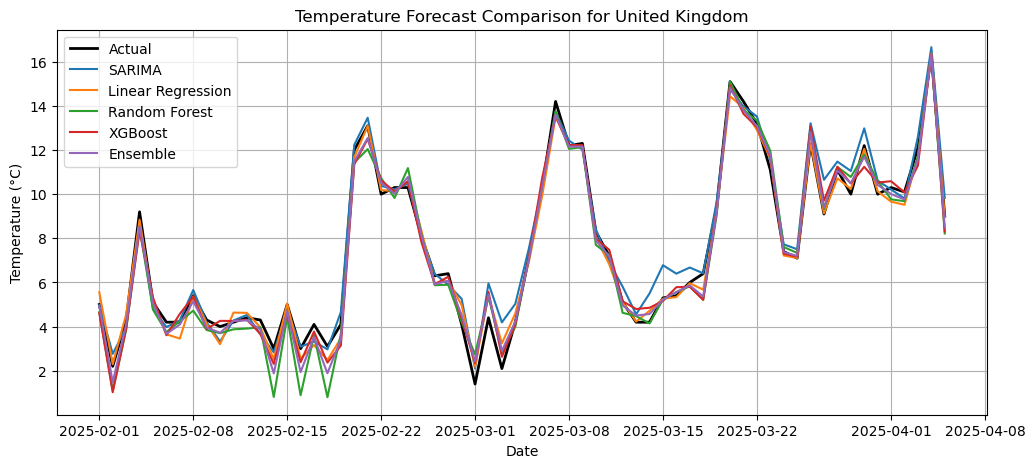

In [35]:
forecast_temperature_by_country('United Kingdom', visualize=True)

# Unique Analyses

In [27]:
# Climate Analysis: Study long-term climate patterns and variations
def analyze_climate_trends():
    df_no_outliers['year'] = df_no_outliers['last_updated'].dt.year
    df_no_outliers['month'] = df_no_outliers['last_updated'].dt.month

    countries = df_no_outliers['country'].unique()
    for country in countries:
        df_country = df_no_outliers[df_no_outliers['country'] == country]
        if df_country.shape[0] < 100:
            continue

        climate_trend = df_country.groupby(['year', 'month'])['temperature_celsius'].mean().unstack()
        plt.figure(figsize=(14, 6))
        sns.heatmap(climate_trend, cmap='coolwarm', annot=False)
        plt.title(f'Monthly Average Temperature (°C) Trend - {country}')
        plt.xlabel('Month')
        plt.ylabel('Year')
        plt.tight_layout()
        plt.show()

In [28]:
# analyze_climate_trends()

In [36]:
# Environmental Analysis: Air quality vs. weather parameters
def analyze_air_quality_correlation():
    air_quality_cols = [
        'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_Carbon_Monoxide',
        'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_Ozone'
    ]
    weather_cols = [
        'temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb', 'precip_mm', 'visibility_km'
    ]

    # Compute correlation matrix
    df_corr = df_no_outliers[air_quality_cols + weather_cols].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_corr.loc[air_quality_cols, weather_cols], annot=True, cmap='coolwarm')
    plt.title("Correlation between Air Quality and Weather Parameters")
    plt.tight_layout()
    # save_path = os.path.join(save_dir, "07_Air_vs_weather_heatmap.png")
    # plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

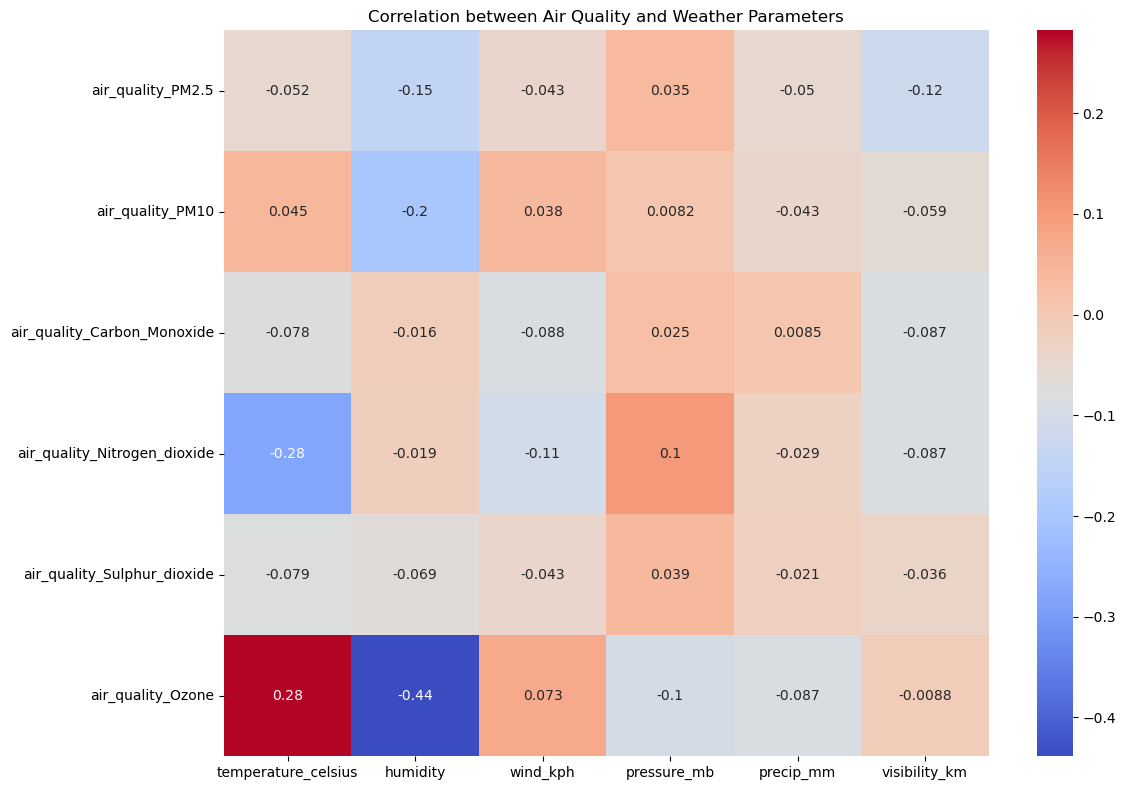

In [37]:
analyze_air_quality_correlation()

In [38]:
# Feature Importance Analysis
def assess_feature_importance():
    feature_cols = [
        'humidity', 'wind_kph', 'gust_kph', 'pressure_mb', 'precip_mm', 'visibility_km',
        'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_Carbon_Monoxide',
        'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_Ozone'
    ]
    target_col = 'temperature_celsius'

    df = df_no_outliers.dropna(subset=feature_cols + [target_col])
    X = df[feature_cols]
    y = df[target_col]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    importances = pd.Series(model.feature_importances_, index=feature_cols)
    importances = importances.sort_values(ascending=True)

    plt.figure(figsize=(10, 6))
    importances.plot(kind='barh')
    plt.title('Feature Importance for Predicting Temperature')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    # save_path = os.path.join(save_dir, "08_imp_features.png")
    # plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

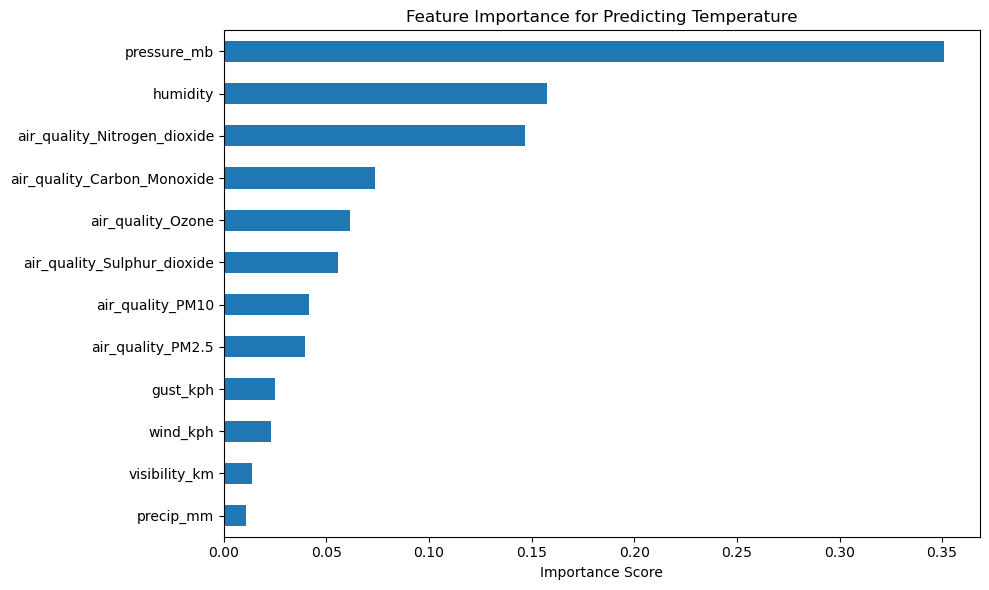

In [39]:
assess_feature_importance()

In [40]:
# Spatial Analysis: Visualize geographical patterns
def spatial_temperature_analysis():
    df_avg = df_no_outliers.groupby(['country', 'latitude', 'longitude'])['temperature_celsius'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(df_avg['longitude'], df_avg['latitude'], c=df_avg['temperature_celsius'], cmap='coolwarm', s=50)
    plt.colorbar(scatter, label='Avg Temperature (°C)')
    plt.title('Geographical Temperature Distribution')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.tight_layout()
    # save_path = os.path.join(save_dir, "09_geographical_temperature_distribution.png")
    # plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

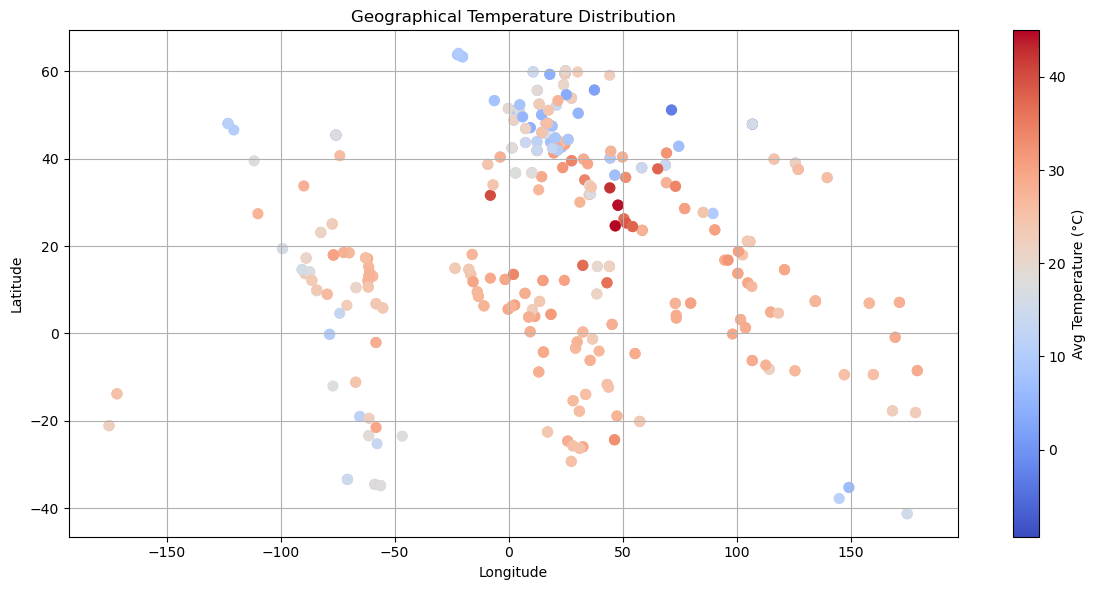

In [41]:
spatial_temperature_analysis()

In [35]:
# Geographical Patterns: Clear comparison using bar plots for top countries
def analyze_geographical_patterns():
    weather_cols = ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 'precip_mm']
    top_countries = df_no_outliers['country'].value_counts().head(10).index
    df_filtered = df_no_outliers[df_no_outliers['country'].isin(top_countries)]
    df_grouped = df_filtered.groupby('country')[weather_cols].mean().reset_index()

    for col in weather_cols:
        plt.figure(figsize=(12, 5))
        sns.barplot(x='country', y=col, data=df_grouped, order=df_grouped.sort_values(by=col, ascending=False)['country'])
        plt.title(f'Average {col} by Country')
        plt.xticks(rotation=45)
        plt.ylabel(col)
        plt.xlabel('Country')
        plt.tight_layout()
        plt.show()

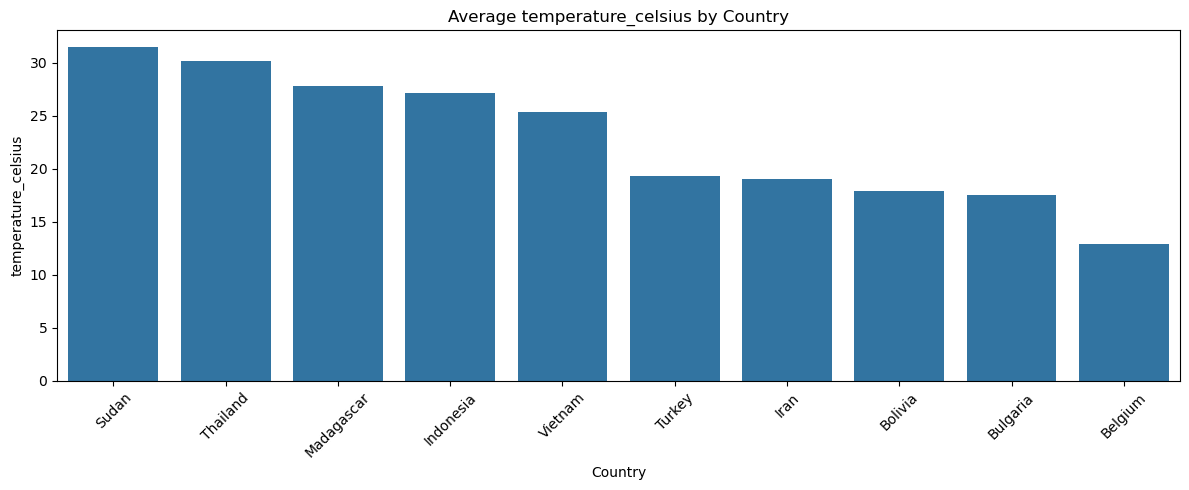

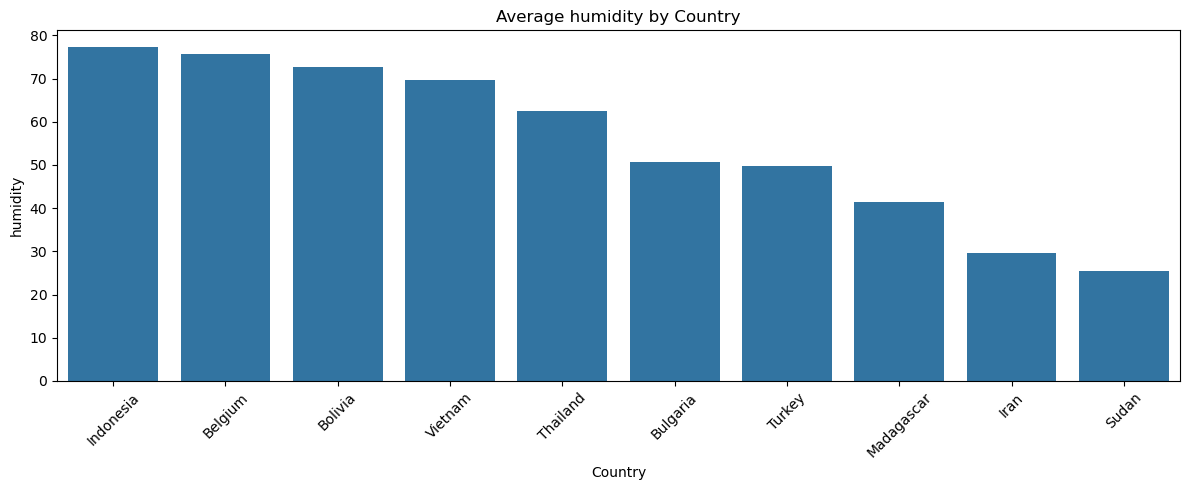

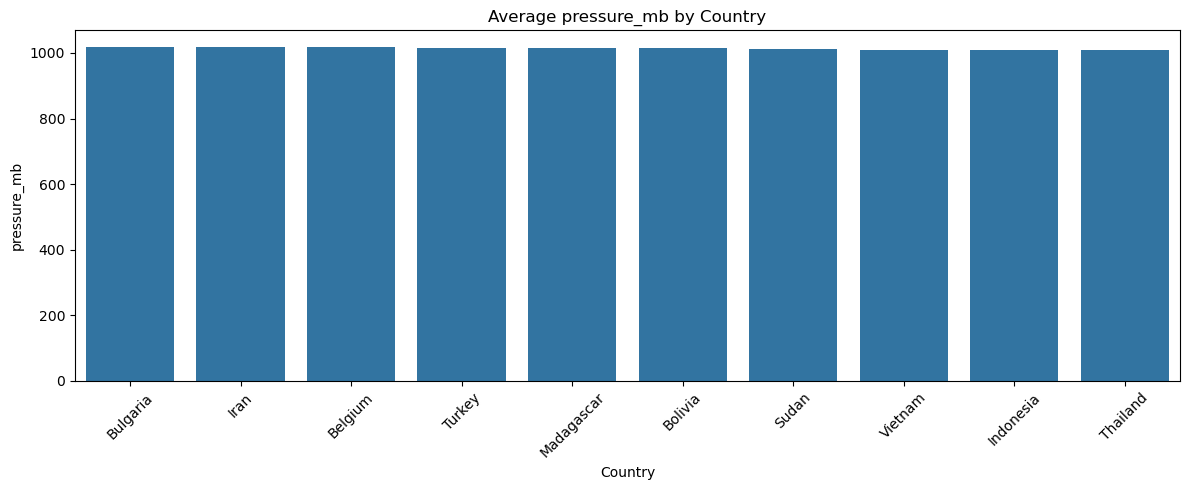

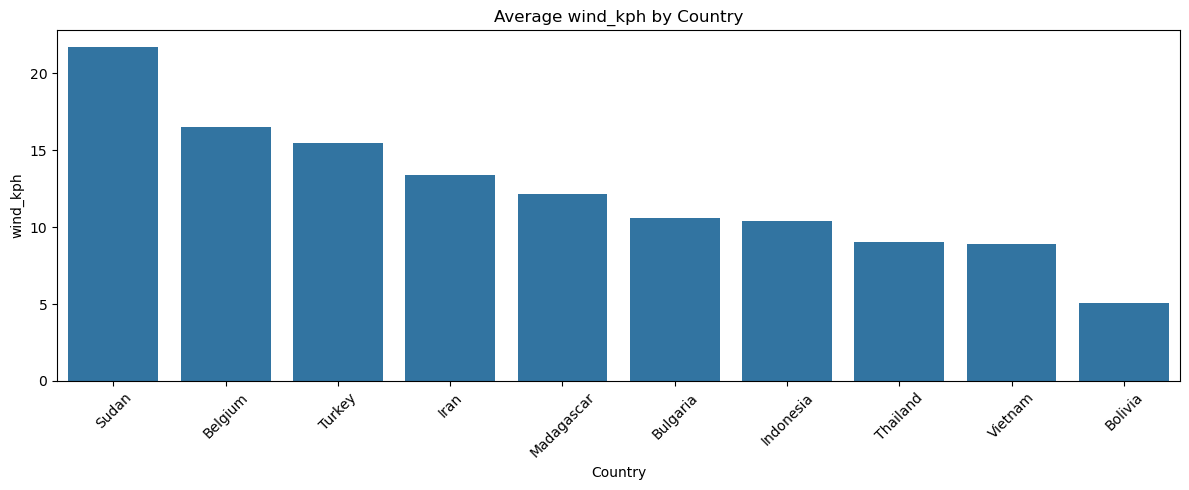

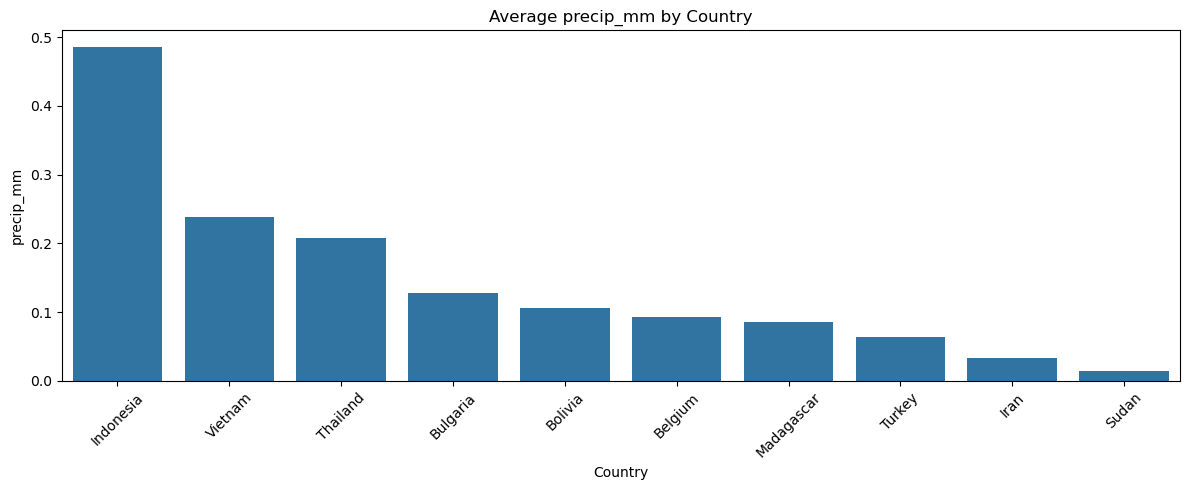

In [36]:
analyze_geographical_patterns()